In [357]:
import numpy as np
import sys 
sys.path.append(r'../../Python Script/')

from sympy import symbols, simplify, derive_by_array
from scipy.integrate import solve_ivp
from xLSINDy import *
from sympy.physics.mechanics import *
from sympy import *
import sympy
import torch
import HLsearch as HL
import matplotlib.pyplot as plt

In [358]:
import time

def torque(t,omega):
    return 1*np.cos(omega*t), 1*np.sin(omega*t)

def doublePendulum(t,y,omega):
    from numpy import sin, cos, sign
    x0,x1,x0_t,x1_t = y
    tau0, tau1 = torque(t, omega)
    x0_tt = (2.0*sin(x0)*sin(x1) + 2.0*cos(x0)*cos(x1))*(tau1 + x0_t**2*sin(x0)*cos(x1) - x0_t**2*sin(x1)*cos(x0) - 9.8*sin(x1))/(2.0*sin(x0)**2*sin(x1)**2 + 4.0*sin(x0)*sin(x1)*cos(x0)*cos(x1) + 2.0*cos(x0)**2*cos(x1)**2 - 4.0) - 2.0*(tau0 - tau1 - x1_t**2*sin(x0)*cos(x1) + x1_t**2*sin(x1)*cos(x0) - 19.6*sin(x0))/(2.0*sin(x0)**2*sin(x1)**2 + 4.0*sin(x0)*sin(x1)*cos(x0)*cos(x1) + 2.0*cos(x0)**2*cos(x1)**2 - 4.0)
    x1_tt =  (1.0*sin(x0)*sin(x1) + 1.0*cos(x0)*cos(x1))*(tau0 - tau1 - x1_t**2*sin(x0)*cos(x1) + x1_t**2*sin(x1)*cos(x0) - 19.6*sin(x0))/(1.0*sin(x0)**2*sin(x1)**2 + 2.0*sin(x0)*sin(x1)*cos(x0)*cos(x1) + 1.0*cos(x0)**2*cos(x1)**2 - 2.0) - 2.0*(tau1 + x0_t**2*sin(x0)*cos(x1) - x0_t**2*sin(x1)*cos(x0) - 9.8*sin(x1))/(1.0*sin(x0)**2*sin(x1)**2 + 2.0*sin(x0)*sin(x1)*cos(x0)*cos(x1) + 1.0*cos(x0)**2*cos(x1)**2 - 2.0)
    return x0_t,x1_t,x0_tt,x1_tt


def generate_data(func, time, init_values, omega):
    sol = solve_ivp(func,[time[0],time[-1]],init_values,t_eval=time, method='LSODA', rtol=1e-10,atol=1e-10, args=[omega])
    return sol.y.T, np.array([func(time[i],sol.y.T[i,:], omega = omega) for i in range(sol.y.T.shape[0])],dtype=np.float64)


In [359]:
#Saving Directory
rootdir = "../../Double Pendulum/"

num_sample = 1
create_data = False
training = False

a = 1
b = 1
noiselevel = a*10**(-b)

In [360]:
states_dim = 4
states = ()
states_dot = ()
for i in range(states_dim):
    if(i<states_dim//2):
        states = states + (symbols('x{}'.format(i)),)
        states_dot = states_dot + (symbols('x{}_t'.format(i)),)
    else:
        states = states + (symbols('x{}_t'.format(i-states_dim//2)),)
        states_dot = states_dot + (symbols('x{}_tt'.format(i-states_dim//2)),)
print('states are:',states)
print('states derivatives are: ', states_dot)

states are: (x0, x1, x0_t, x1_t)
states derivatives are:  (x0_t, x1_t, x0_tt, x1_tt)


In [361]:
#Turn from sympy to str
states_sym = states
states_dot_sym = states_dot
states = list(str(descr) for descr in states)
states_dot = list(str(descr) for descr in states_dot)

In [362]:
# identifier = "no"
identifier = str(a) + "e-0" + str(b)
if(training==False):
    with open(rootdir + "Data/Active/lagrangian_" + identifier + "_noise.txt") as f:
        L = f.readline()
        print(L)
        expr = L.split(" +")
        device = "cuda:0"
        xi_L = torch.ones(len(expr),device=device)
        mask = torch.ones(len(expr),device=device)

0.26*x0_t**2 + 0.26*x0_t*x1_t*cos(x0 - x1) + 0.13*x1_t**2 + 5.18*cos(x0) + 2.66*cos(x1)


In [363]:
#for lagrangian
x0 = dynamicsymbols(states[0], real=True)
x1 = dynamicsymbols(states[1], real=True)
x0_t = dynamicsymbols(states[0],1, real=True)
x1_t = dynamicsymbols(states[1],1, real=True)
tau0 = symbols('tau0')
tau1 = symbols('tau1')

#True Lagrangian
L = eval(str(L))

# Lagrange's method
LM = LagrangesMethod(L, [x0,x1])
LM.form_lagranges_equations()
i_forcing = LM.forcing #internal forcing and gravity
e_forcing = sympy.Matrix([tau0-tau1, tau1]) #external generalized force

In [364]:
# Substituting dynamic symbols

i_forcing = i_forcing.subs(x0_t, states_sym[2])
i_forcing = i_forcing.subs(x1_t, states_sym[3])
i_forcing = i_forcing.subs(x0, states_sym[0])
i_forcing = i_forcing.subs(x1, states_sym[1])

M = LM.mass_matrix
M = M.subs(x0, states_sym[0])
M = M.subs(x1, states_sym[1])

In [365]:
# Generating equation of motion
t_forcing = i_forcing + e_forcing
eom = M.inv()*sympy.Matrix(t_forcing)

In [366]:
''' Please copy the string shown to the definition of equation in the function of double pendulum'''
for i in range(len(eom)):
    print('Equation ' + str(i) +': ' + str(eom[i]))
    print('\n')

Equation 0: 0.1352*(tau1 + 0.26*x0_t*x1_t*sin(x0 - x1) + 0.26*x0_t*(x0_t - x1_t)*sin(x0 - x1) - 2.66*sin(x1))*cos(x0 - x1)/(0.035152*cos(x0 - x1)**2 - 0.070304) + 0.1352*(tau0 - tau1 - 0.26*x0_t*x1_t*sin(x0 - x1) + 0.26*x1_t*(x0_t - x1_t)*sin(x0 - x1) - 5.18*sin(x0))/(0.070304 - 0.035152*cos(x0 - x1)**2)


Equation 1: 0.26*(tau0 - tau1 - 0.26*x0_t*x1_t*sin(x0 - x1) + 0.26*x1_t*(x0_t - x1_t)*sin(x0 - x1) - 5.18*sin(x0))*cos(x0 - x1)/(0.0676*cos(x0 - x1)**2 - 0.1352) + 0.52*(tau1 + 0.26*x0_t*x1_t*sin(x0 - x1) + 0.26*x0_t*(x0_t - x1_t)*sin(x0 - x1) - 2.66*sin(x1))/(0.1352 - 0.0676*cos(x0 - x1)**2)




In [367]:
import time

def torque(t,omega):
    return 1*np.cos(omega*t), 1*np.sin(omega*t)

def predicteddoublependulum(t,y,omega):
    from numpy import sin, cos
    tau0, tau1 = torque(t, omega)
    x0,x1,x0_t,x1_t = y
    x0_tt = 0.1352*(tau1 + 0.26*x0_t*x1_t*sin(x0 - x1) + 0.26*x0_t*(x0_t - x1_t)*sin(x0 - x1) - 2.66*sin(x1))*cos(x0 - x1)/(0.035152*cos(x0 - x1)**2 - 0.070304) + 0.1352*(tau0 - tau1 - 0.26*x0_t*x1_t*sin(x0 - x1) + 0.26*x1_t*(x0_t - x1_t)*sin(x0 - x1) - 5.18*sin(x0))/(0.070304 - 0.035152*cos(x0 - x1)**2)
    x1_tt = 0.26*(tau0 - tau1 - 0.26*x0_t*x1_t*sin(x0 - x1) + 0.26*x1_t*(x0_t - x1_t)*sin(x0 - x1) - 5.18*sin(x0))*cos(x0 - x1)/(0.0676*cos(x0 - x1)**2 - 0.1352) + 0.52*(tau1 + 0.26*x0_t*x1_t*sin(x0 - x1) + 0.26*x0_t*(x0_t - x1_t)*sin(x0 - x1) - 2.66*sin(x1))/(0.1352 - 0.0676*cos(x0 - x1)**2)
    return x0_t,x1_t,x0_tt,x1_tt

    
def doublePendulum(t,y,omega):
    from numpy import sin, cos, sign
    x0,x1,x0_t,x1_t = y
    tau0, tau1 = torque(t, omega)
    x0_tt = (2.0*sin(x0)*sin(x1) + 2.0*cos(x0)*cos(x1))*(tau1 + x0_t**2*sin(x0)*cos(x1) - x0_t**2*sin(x1)*cos(x0) - 9.8*sin(x1))/(2.0*sin(x0)**2*sin(x1)**2 + 4.0*sin(x0)*sin(x1)*cos(x0)*cos(x1) + 2.0*cos(x0)**2*cos(x1)**2 - 4.0) - 2.0*(tau0 - tau1 - x1_t**2*sin(x0)*cos(x1) + x1_t**2*sin(x1)*cos(x0) - 19.6*sin(x0))/(2.0*sin(x0)**2*sin(x1)**2 + 4.0*sin(x0)*sin(x1)*cos(x0)*cos(x1) + 2.0*cos(x0)**2*cos(x1)**2 - 4.0)
    x1_tt =  (1.0*sin(x0)*sin(x1) + 1.0*cos(x0)*cos(x1))*(tau0 - tau1 - x1_t**2*sin(x0)*cos(x1) + x1_t**2*sin(x1)*cos(x0) - 19.6*sin(x0))/(1.0*sin(x0)**2*sin(x1)**2 + 2.0*sin(x0)*sin(x1)*cos(x0)*cos(x1) + 1.0*cos(x0)**2*cos(x1)**2 - 2.0) - 2.0*(tau1 + x0_t**2*sin(x0)*cos(x1) - x0_t**2*sin(x1)*cos(x0) - 9.8*sin(x1))/(1.0*sin(x0)**2*sin(x1)**2 + 2.0*sin(x0)*sin(x1)*cos(x0)*cos(x1) + 1.0*cos(x0)**2*cos(x1)**2 - 2.0)
    return x0_t,x1_t,x0_tt,x1_tt


def generate_data(func, time, init_values, omega):
    sol = solve_ivp(func,[time[0],time[-1]],init_values,t_eval=time, method='LSODA', rtol=1e-10,atol=1e-10, args=[omega])
    return sol.y.T, np.array([func(time[i],sol.y.T[i,:], omega = omega) for i in range(sol.y.T.shape[0])],dtype=np.float64)




In [368]:
## SINDy-PI ##

'''file name : Double Pendulum/Data/SINDy-PI_2e-02_noise.txt'''

def SINDyPI(t,y):
    from numpy import sin, cos
    z1,z2,z3,z4 = y
    dz1=1.0*z3
    dz2=z4
    dz3=(2.292e+7*sin(2.0*z1 - 2.0*z2) - 2.093e+7*sin(2.0*z1 - 1.0*z2) + 2.005e+7*sin(z1 - z2) + 1.238e+7*sin(z1 - 2.0*z2) + 7.062e+7*sin(z1) - 5.678e+6*sin(z2) + 1.477e+6*z3**2*sin(2.0*z1 - 1.0*z2) + 1.06e+6*z4**2*sin(2.0*z1 - 1.0*z2) - 1.609e+6*z4**2*sin(2.0*z1 - 2.0*z2) - 1.887e+6*z3**2*sin(z1 - z2) + 3.678e+6*z4**2*sin(z1 - z2) + 1.541e+6*z3**2*sin(z1 - 2.0*z2) + 9.951e+5*z4**2*sin(z1 - 2.0*z2))/(6.543e+6*cos(z1 - 1.0*z2)**2 - 1.0e+7)
    dz4=-(1.0*(8.16*sin(2.0*z1 - 1.0*z2) + 3.179*sin(2.0*z1 - 2.0*z2) - 2.906*sin(z1 - z2) + 1.408*sin(z1) - 9.208*sin(z2) + 0.8598*z3**2*sin(z1 - z2)))/(cos(z1 - 1.0*z2)**2 - 1.307)
    return dz1, dz2, dz3, dz4

In [369]:
## Training Results ##
import matplotlib.pyplot as plt
  
t = np.arange(0,10,0.01)
omega = 0.47677687576540795#np.random.uniform(0,np.pi/3)
theta1 = -0.08624847086272625#np.random.uniform(-np.pi/3,np.pi/3)
thetadot = np.random.uniform(0,0)
theta2 = -0.5864635379254604#np.random.uniform(-np.pi/3,np.pi/3)

y0=np.array([theta1, theta2, thetadot, thetadot])

tau0, tau1 = torque(t, omega)
tau = np.array([tau0 - tau1, tau1]).T    


#true value
X,Xdot = generate_data(doublePendulum,t,y0,omega=omega)

#prediction
Xpred,Xdotpred = generate_data(predicteddoublependulum,t,y0,omega=omega)


q_tt_true_wn = (Xdot[:,states_dim//2:].T).copy()
q_t_true_wn = (Xdot[:,:states_dim//2].T).copy()
q_true_wn = (X[:,:states_dim//2].T).copy()

#adding noise
mu, sigma = 0, noiselevel
noise = np.random.normal(mu, sigma, X.shape[0])
noise[500:] = 0
for i in range(X.shape[1]):
    X[:,i] = X[:,i]+noise
    Xdot[:,i] = Xdot[:,i]+noise

q_tt_true = Xdot[:,states_dim//2:].T
q_t_true = Xdot[:,:states_dim//2].T
q_true = X[:,:states_dim//2].T

#xL-SINDy (active)
Xpred, Xdotpred = generate_data(predicteddoublependulum, t, y0, omega=omega) 

q_tt_pred = Xdotpred[:,states_dim//2:].T
q_t_pred = Xdotpred[:,:states_dim//2].T
q_pred = Xpred[:,:states_dim//2].T



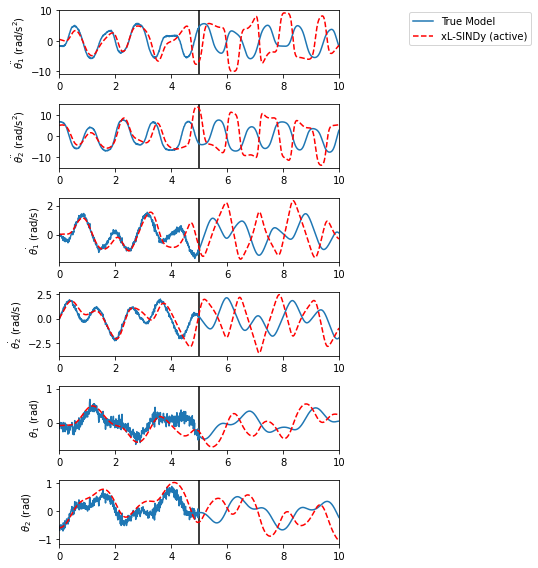

In [370]:
fig, ax = plt.subplots(6,1,figsize=(5,8))

ax[0].plot(t, q_tt_true[0,:], label='True Model')
ax[0].plot(t, q_tt_pred[0,:], 'r--',label='xL-SINDy (active)')
#ax[0].plot(t, q_tt_spi[0,:], ':g', label='SINDy-PI')
ax[0].set_ylabel('$\ddot{\\theta_1}$ (rad/s$^2$)')
ax[0].vlines(5,0,1,transform=ax[0].get_xaxis_transform(),colors='k')
ax[0].set_xlim([0,10])

ax[1].plot(t, q_tt_true[1,:], label='True Model')
ax[1].plot(t, q_tt_pred[1,:], 'r--',label='xL-SINDy (active)')
#ax[1].plot(t, q_tt_spi[1,:], ':g',label='SINDy-PI')
ax[1].set_ylabel('$\ddot{\\theta_2}$ (rad/s$^2$)')
ax[1].vlines(5,0,1,transform=ax[1].get_xaxis_transform(),colors='k')
ax[1].set_xlim([0,10])

ax[2].plot(t, q_t_true[0,:], label='True Model')
ax[2].plot(t, q_t_pred[0,:], 'r--',label='xL-SINDy (active)')
#ax[2].plot(t, q_t_spi[0,:], ':g',label='SINDy-PI')
ax[2].set_ylabel('$\dot{\\theta_1}$ (rad/s)')
ax[2].vlines(5,0,1,transform=ax[2].get_xaxis_transform(),colors='k')
ax[2].set_xlim([0,10])

ax[3].plot(t, q_t_true[1,:], label='True Model')
ax[3].plot(t, q_t_pred[1,:], 'r--',label='xL-SINDy (active)')
#ax[3].plot(t, q_t_spi[1,:], ':g',label='SINDy-PI')
ax[3].set_ylabel('$\dot{\\theta_2}$ (rad/s)')
ax[3].vlines(5,0,1,transform=ax[3].get_xaxis_transform(),colors='k')
ax[3].set_xlim([0,10])

ax[4].plot(t, q_true[0,:], label='True Model')
ax[4].plot(t, q_pred[0,:], 'r--',label='xL-SINDy (active)')
#ax[4].plot(t, q_spi[0,:], ':g',label='SINDy-PI')
ax[4].set_ylabel('$\\theta_1$ (rad)')
ax[4].vlines(5,0,1,transform=ax[4].get_xaxis_transform(),colors='k')
ax[4].set_xlim([0,10])
#ax[4].set_ylim([-1.8,1.8])

ax[5].plot(t, q_true[1,:], label='True Model')
ax[5].plot(t, q_pred[1,:], 'r--',label='xL-SINDy (active)')
#ax[5].plot(t, q_spi[1,:], ':g',label='SINDy-PI')
ax[5].set_ylabel('$\\theta_2$ (rad)')
ax[5].vlines(5,0,1,transform=ax[5].get_xaxis_transform(),colors='k')
ax[5].set_xlim([0,10])
#ax[5].set_ylim([-4,4])

Line, Label = ax[0].get_legend_handles_labels()
fig.legend(Line, Label, loc='upper right', bbox_to_anchor=(1.5, 0.98))

fig.tight_layout()
fig.savefig(rootdir + "Images/Active/training_" + identifier + "_noise.png", bbox_inches='tight',dpi=400)


In [371]:
np.save(rootdir + "Data/Active/q_pred_" + identifier + "_noise.png", q_pred)
np.save(rootdir + "Data/Active/q_true", q_true)